# **Description**

Build distribution charts in spam and non-spam sets of the following features:

1 Number of words per page
2 Average word length
3 Number of words in the page title (words in the <html><head> <title> Some text </title> tag)
4 Number of words in link anchors (<html> <body> <a> Some text </a>)
5 compression ratio

It is necessary to calculate the statistics for at least three signs and be sure to do for the 1st and 2nd signs

And send the first decision to the competition https://kaggle.com/join/antispam_infopoisk
Based on one of the above signs, try to divide the number so that the score in the competition is more than 0.55

If all these conditions are met during the seminar, +1 point to DZ

Description of DZ and the rules for setting points for it at https://inclass.kaggle.com/c/antispam-infopoisk
To specify the terms of DZ with the teacher - usually 2 weeks

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from importlib import reload

In [99]:
from __future__ import division
! pip install ftfy

import base64
import csv
import gzip
import zlib
import ftfy

from collections import namedtuple

%matplotlib inline
import matplotlib.pyplot as plt

     |████████████████████████████████| 61kB 2.0MB/s 
  Created wheel for ftfy: filename=ftfy-5.6-cp36-none-any.whl size=44553 sha256=f7d715885d7266be15ffcfcb879a904ccc10c1caf664efa8af6044ca61ef7d67
  Stored in directory: /root/.cache/pip/wheels/43/34/ce/cbb38d71543c408de56f3c5e26ce8ba495a0fa5a28eaaf1046
Successfully built ftfy


In [0]:
TRACE_NUM = 1000
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

def trace(items_num, trace_num=TRACE_NUM):
    if items_num % trace_num == 0: logging.info("Complete items %05d" % items_num)

### Utilities

#### Decorators

In [0]:
def to_utf8(text):
    if isinstance(text, str): text = text.encode("ISO-8859-1")
    return text

def convert2unicode(f):
    def tmp(text):
        if not isinstance(text, str): text = ftfy.fix_text(text.decode("latin-1"))
        return f(text)
    return tmp

def convert2lower(f):
    def tmp(text):        
        return f(text.lower())
    return tmp

#P.S. Decorators can complicate debugging, so you can completely discard them and use copy-paste

### Extract text from html

#### Extraction of text using built-in modules

In [0]:
from html.parser import HTMLParser
import re

###Extracting text from title can be entered here

class TextHTMLParser(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self._text = []
        self._title = ""
        self._in_title = False

    def handle_data(self, data):
        text = data.strip()
        if len(text) > 0:
            text = re.sub('[ \t\r\n]+', ' ', text)
            self._text.append(text + ' ')

    def handle_starttag(self, tag, attrs):
        if tag == 'p':
            self._text.append('\n\n')
        elif tag == 'br':
            self._text.append('\n')
        elif tag == 'title':
            self._in_title = True

    def handle_startendtag(self, tag, attrs):
        if tag == 'br':
            self._text.append('\n\n')

    def text(self):
        return ''.join(self._text).strip()
    
    def extract_title(self):
        soup = BeautifulSoup(text)
        if soup.title != None:
            self._title = soup.title.string

@convert2unicode
def html2text_parser(text):
    parser = TextHTMLParser()
    parser.feed(text)
    soup = BeautifulSoup(text)
    title = ""
    if soup.title != None:
        title = soup.title.string
    anchor = ""
    if soup.find('a') != None:
        anchor = soup.find('a').text
        
    return parser.text(), title, anchor

In [0]:
from bs4 import BeautifulSoup

#### Extraction of text using additional libraries

In [0]:
def html2text_bs(raw_html):
    """
    Here is the extraction of text from html
    """
    soup = BeautifulSoup(raw_html, "html.parser")
    [s.extract() for s in soup(['script', 'style'])]
    return soup.get_text()

def html2text_bs_visible(raw_html):
    """
    Here the text is extracted from the html, which is visible to the user
    """
    soup = BeautifulSoup(raw_html, "html.parser")    
    [s.extract() for s in soup(['style', 'script', '[document]', 'head', 'title'])]
    return soup.get_text()

def html2text_boilerpipe(raw_html):
    import boilerpipe
    """
    another library that extracts the text that is visible to the user very well,
    but it is tied to java
    """
    pass

#### Choose which method to convert html to text will be the main

In [0]:
#html2text = html2text_bs
html2text = html2text_parser

#### Methods for tokenizing text

In [0]:
@convert2lower
@convert2unicode
def easy_tokenizer(text):
    word = str()
    for symbol in text:
        if symbol.isalnum(): word += symbol
        elif word:
            yield word
            word = str()
    if word: yield word

PYMORPHY_CACHE = {}
MORPH = None
#hint so that installing pymorphy2 would not be required
def get_lemmatizer():
    import pymorphy2
    global MORPH
    if MORPH is None: MORPH = pymorphy2.MorphAnalyzer()
    return MORPH

@convert2lower
@convert2unicode
def pymorphy_tokenizer(text):
    global PYMORPHY_CACHE
    for word in easy_tokenizer(text):
        word_hash = hash(word)
        if word_hash not in PYMORPHY_CACHE:
            PYMORPHY_CACHE[word_hash] = get_lemmatizer().parse(word)[0].normal_form            
        yield PYMORPHY_CACHE[word_hash]

#### The main function that is called to convert html to a list of words

In [0]:
def html2word(raw_html, to_text=html2text, tokenizer=easy_tokenizer):
    text, title, anchor = to_text(raw_html)
    if title == None:
        title = ""
    if anchor == None:
        anchor = ""
    return tokenizer(text.lower()), tokenizer(title.lower()), tokenizer(anchor.lower())

#### Calculation of final metrics

In [0]:
def safe_divide(a, b):
    if a == 0: return 0.0
    elif b == 0: return 0.0
    else: return a/b

def calculate_metrics(predictions, threshold):    
    """
    Metric counting function
    Options
    predictions - document rank
    threshold - threshold for metrics
    """
    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0
    for (url_id, mark, url, prediction) in predictions:        
        mark_predict = prediction > threshold

        if mark_predict:                     
            if mark_predict == mark: true_positive += 1
            else: false_positive += 1                    
        else:                     
            if  mark_predict == mark: true_negative += 1
            else: false_negative += 1

    class_prec  = safe_divide(true_positive, true_positive + false_positive)
    class_recall = safe_divide(true_positive, true_positive + false_negative)
        
    class_F1 = safe_divide(2 * class_prec * class_recall, class_prec + class_recall)
    
    
    not_class_prec = safe_divide(true_negative, true_negative + false_negative)
    not_class_recall = safe_divide(true_negative, true_negative + false_positive)
    
    not_class_F1 = safe_divide(2 * not_class_prec * not_class_recall, not_class_prec + not_class_recall)
    
    return ( (class_prec, class_recall, class_F1), (not_class_prec, not_class_recall, not_class_F1) )

def arange(start, stop, step):
    cur_value = start
    while True:
        if cur_value > stop: break
        yield cur_value
        cur_value += step

def plot_results(docs, min_threshold=-1, max_threshold=1, step=0.1, trace=False):
    x = []
    y_p = []
    y_n = []
    docs_predictions = classifier.predict_all(docs)
    for threshold in arange(min_threshold, max_threshold, step):
        r = calculate_metrics(docs_predictions, threshold)
        x.append(threshold)
        y_p.append(r[0])
        y_n.append(r[1])        
        if trace: 
            print('threshold %s' % threshold)
            print('\tclass_prec %s, class_recall %s, class_F1 %s' % r[0])
            print('\tnot_class_prec %s, not_class_recall %s, not_class_F1 %s' % r[1])
            print('\t\tMacroF1Mesure %s' % ((r[0][2] + r[1][2])/2))
    plot_stats(x, y_p, "Class Result")
    plot_stats(x, y_n, "Not class Result")    


def plot_stats(x, y, title):
    plt.figure(figsize=(10, 5))

    prec, = plt.plot( x, 
                     [k[0] for k in y], "r", label='Precision', 
                     linewidth=1)
    accur, = plt.plot( x, 
                      [k[1] for k in y], "b", label='Recall',
                      linewidth=1)
    f1, =    plt.plot( x, 
                      [k[2] for k in y], "g", label='F1',
                      linewidth=1)
    plt.grid(True)
    plt.legend(handles=[prec, accur, f1])
    plt.title(title)
    plt.show()

In [0]:
def calc_features(url, html_data):
    words, title, anchor = html2word(html_data)

    anchor = list(anchor)
    words = list(words)
    title = list(title)
    words_num = len(words)
    # print(words, title, anchor)
    
    avg_word_len = 0
    for word in words:
        avg_word_len += len(word)
    avg_word_len = avg_word_len/words_num
    title_words_num = len(title)    
    anchor_words_num = len(anchor)
    compression_level = 0
    
    return [len(words), avg_word_len, title_words_num, anchor_words_num, compression_level, words]

In [128]:
test_html_data = u'''
<html>
<title> Заголовок Ololo </title>
спам 1 2 3
'<html><body><a> Some text </a>'
</html>
'''
test_url = 'http://ololo'
test_features = calc_features(test_url, test_html_data)
print(test_features)

[8, 3.625, 2, 2, 0, ['заголовок', 'ololo', 'спам', '1', '2', '3', 'some', 'text']]


In [0]:
DocItem = namedtuple('DocItem', ['doc_id', 'is_spam', 'url', 'features', 'words'])

def load_csv(input_file_name, calc_features_f):    
    """
    We load data and extract signs on the fly
    Content itself is not saved to reduce memory consumption - to
    could run even on laptops in class
    """
    
    with gzip.open(input_file_name) if input_file_name.endswith('gz') else open(input_file_name)  as input_file:            
        headers = input_file.readline()
        
        for i, line in enumerate(input_file):
            trace(i)
            #print(line)
            if i > 10:
                break
            line = line.decode()
            parts = line.strip().split('\t')
            url_id = int(parts[0])                                        
            mark = bool(int(parts[1]))                    
            url = parts[2]
            pageInb64 = parts[3]
            html_data = base64.b64decode(pageInb64)
            features = calc_features_f(url, html_data)      
            yield DocItem(url_id, mark, url, features[:-1], features[-1])            
                
        trace(i, 1)        

** We process the input file **
<br>
Format - fields separated by tabs
<br>
0 - document id
<br>
1 - class label 0 - not spam, 1 - spam
<br>
2 - url of the document
<br>
3 - base64 encoded document
#### I Added
4 - Words

The output format is an array of tuples of the form
(doc_id, is_spam, url, html_data, **words**)

In [0]:
import pandas as pd

In [84]:
import os
os.getcwd()
os.listdir()
os.listdir()

['.config', 'drive', 'sample_data']

In [85]:
os.path.exists('drive/My Drive/Homeworks/InformationRetrieval/hw3/kaggle_test_data_tab_new.csv.gz')

True

In [130]:
%%time

file_location = 'drive/My Drive/Homeworks/InformationRetrieval/hw3/kaggle_train_data_tab_new.csv.gz'
TRAIN_DATA_FILE  = file_location

train_docs = list(load_csv(TRAIN_DATA_FILE, calc_features))

12:25:46 INFO:Complete items 00000
12:25:47 INFO:Complete items 00011


CPU times: user 799 ms, sys: 11 ms, total: 810 ms
Wall time: 818 ms


In [131]:
train_docs[:5]
temp = pd.DataFrame(train_docs)
temp['words'] = temp['words'].apply(lambda x: [ftfy.fix_text(y) for y in x])
temp.head()

,doc_id,is_spam,url,features,words
0,-9222401963271173253,False,http://lawleader.ru/docs/32/,"[3359, 6.318547186662697, 4, 1, 0]","[договор, займа, договоры, договора, function,..."
1,-9221399504663603656,False,http://alterhost.ruwww.alterhost.ruwww.user.kz...,"[956, 4.908995815899582, 3, 1, 0]","[uzru, миры, общения, domain, discovery, backg..."
2,-9219733223042265364,False,http://www.ferio.ru/c_1-acura-legend.html,"[1551, 4.8807221147646676, 7, 2, 0]","[ferio, ru, ремонт, и, автозапчасти, acura, le..."
3,-9218561774155397294,False,http://fshops.otzyv.ru/read.php?id=277,"[1062, 4.869114877589454, 3, 0, 0]","[как, повесить, штору, function, checkuser, if..."
4,-9216163564171210203,True,http://penhea895.narod.ru/familiya-shushmarche...,"[522, 5.241379310344827, 4, 1, 0]","[фамилия, шушмарченко, французские, фамилии, b..."


'ð'

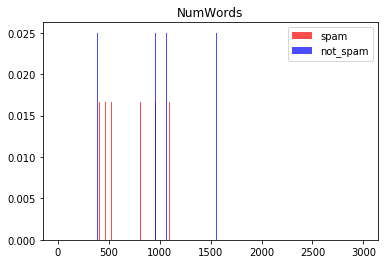

In [132]:
is_spam_data = [doc.features[0] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[0] for doc in train_docs if doc[1] == False]
bins = range(0,3000,10)
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('NumWords')
plt.legend()
plt.show()

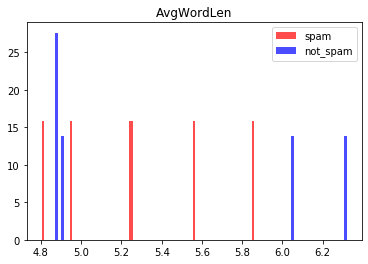

In [133]:
is_spam_data = [doc.features[1] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[1] for doc in train_docs if doc[1] == False]
bins = 100
plt.hist(is_spam_data, bins=bins, color='red', density=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', density=True, alpha=0.7, label='not_spam')
plt.title('AvgWordLen')
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  """


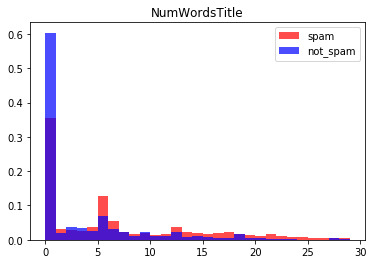

In [23]:
is_spam_data = [doc.features[3] for doc in train_docs if doc[1] == True]
not_spam_data = [doc.features[3] for doc in train_docs if doc[1] == False]
bins = range(0, 30, 1)
plt.hist(is_spam_data, bins=bins, color='red', normed=True, alpha=0.7, label='spam')
plt.hist(not_spam_data, bins=bins, color='blue', normed=True, alpha=0.7, label='not_spam')
plt.title('NumWordsTitle')
plt.legend()
plt.show()

In [0]:
# Add graphics for other features

** Classifier: **
Need to implement

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [0]:
train_data = pd.DataFrame(train_docs)
X_train = train_data['words']
y_train = train_data['is_spam'].replace({True: 1, False: 0})

In [40]:
tf = TfidfVectorizer()
X_train = tf.fit_transform(X_train)

AttributeError: ignored

In [32]:
X_train.shape, y_train.shape

AttributeError: ignored

In [25]:
pd.DataFrame(train_docs[:5])

,doc_id,is_spam,url,features,words
0,-9222401963271173253,False,http://lawleader.ru/docs/32/,"[13071, 2.20434549766659, 11, 5, 0]","[ð, ð¾ð³ð¾ð²ð¾ñ, ð, ð, ð¹ð¼ð, ð, ð¾ð³ð¾ð²ð¾ñ, ..."
1,-9221399504663603656,False,http://alterhost.ruwww.alterhost.ruwww.user.kz...,"[2049, 2.6012689116642265, 8, 5, 0]","[uzru, ð¼ð, ñ, ñ, ð¾ð, ñ, ðµð½ð, ñ, domain, di..."
2,-9219733223042265364,False,http://www.ferio.ru/c_1-acura-legend.html,"[4212, 2.221272554605888, 17, 10, 0]","[ferio, ru, ñ, ðµð¼ð¾ð½ñ, ð, ð, ð²ñ, ð¾ð, ð, ð..."
3,-9218561774155397294,False,http://fshops.otzyv.ru/read.php?id=277,"[2647, 2.365697015489233, 12, 0, 0]","[ð, ð, ðº, ð, ð¾ð²ðµñ, ð, ñ, ñ, ñ, ñ, ð¾ñ, ñ, ..."
4,-9216163564171210203,True,http://penhea895.narod.ru/familiya-shushmarche...,"[1639, 2.1287370347773034, 28, 5, 0]","[ð, ð, ð¼ð, ð, ð, ñ, ð, ñ, ñ, ð¼ð, ñ, ñ, ðµð½ð..."


In [0]:
from sklearn.neural_network import MLPClassifier
import numpy as np

In [0]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [0]:
parameters = {'learning_rate':[1, 0.5, 0.25, 0.1, 0.05, 0.01], 'n_estimators':[1, 2, 4, 8, 16, 32, 64, 100, 200],
             'max_depth':np.linspace(1, 32, 32, endpoint=True),'min_samples_split':np.linspace(0.1, 1.0, 10, endpoint=True)}
clf = GradientBoostingClassifier()
gs = GridSearchCV(clf, parameters, verbose = True, n_jobs = -1)
gs.fit(data, target)

Fitting 3 folds for each of 17280 candidates, totalling 51840 fits


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 6034 tasks      |

GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_it...
             param_grid={'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 

In [0]:
best_params = gs.best_params_
best_params

{'learning_rate': 0.25,
 'max_depth': 3.0,
 'min_samples_split': 0.1,
 'n_estimators': 200}

In [0]:
data = []
target = []
for s in train_docs:
    data.append(s.features[:3])
    target.append(s.is_spam)

In [0]:
class Classifier:
    
    def __init__(self):
        
        self.clf = GradientBoostingClassifier(learning_rate= 0.25, max_depth= 3.0, min_samples_split= 0.1,
                                              n_estimators= 200, verbose = True)
        pass

    def predict(self, doc):       
        print([doc.features[:4]])
        return self.clf.predict([doc.features[:4]])                    
    
    def predict_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            #if doc_num > 500:
                #break
            trace(doc_num)
            prediction = self.predict(doc)            
            res.append( (doc.doc_id, doc.is_spam, doc.url, prediction) )
        return res
    
    def predict_proba(self, doc):
        return self.clf.predict_proba([doc.features[:4]])    
    
    def predict_proba_all(self, docs):
        res = []
        for doc_num, doc in enumerate(docs):
            trace(doc_num)
            proba = self.predict_proba(doc)            
            res.append(proba)
        return res
    
    def train(self, docs):
        features = []
        labels = []
        for doc_num, doc in enumerate(docs):
            features.append(doc.features)
            labels.append(doc.is_spam)
            #TODO вставить код обучения
            trace(doc_num)
        features = np.array(features)[:,:4]
        self.clf.fit(features,labels)
        print(self.clf.feature_importances_)
        trace(doc_num, 1)

In [0]:
train_train = train_docs[:5500]
train_val = train_docs[5500:]

In [0]:
classifier = Classifier()
classifier.train(train_train)

17:45:34 INFO:Complete items 00000
17:45:34 INFO:Complete items 01000
17:45:34 INFO:Complete items 02000
17:45:34 INFO:Complete items 03000
17:45:34 INFO:Complete items 04000
17:45:34 INFO:Complete items 05000


      Iter       Train Loss   Remaining Time 
         1           1.2294            0.55s
         2           1.1504            0.55s
         3           1.1008            0.53s
         4           1.0649            0.52s
         5           1.0399            0.52s
         6           1.0180            0.51s
         7           0.9987            0.51s
         8           0.9824            0.50s
         9           0.9694            0.49s
        10           0.9583            0.49s
        20           0.9155            0.48s
        30           0.8930            0.42s
        40           0.8747            0.37s
        50           0.8617            0.36s
        60           0.8502            0.32s
        70           0.8421            0.28s
        80           0.8340            0.25s
        90           0.8255            0.22s
       100           0.8173            0.20s


17:45:34 INFO:Complete items 05499


       200           0.7471            0.00s
[0.30034742 0.46122268 0.11286008 0.12556982]


In [0]:
# See what is predicted for test html
classifier.predict(DocItem(0, 0, test_url , test_features))

NameError: name 'classifier' is not defined

In [0]:
probs_true = np.array(probs)[:,0][:,1]
breds2 = probs_true > 0.5

In [0]:
f1_score(list(np.array(breds)[:,1]), list(np.array(breds)[:,3]), labels = [True, False],average = None)

array([0.82599119, 0.75157233])

In [0]:
np.sum(f1_score(list(np.array(breds)[:,1]), list(np.array(breds)[:,3]), average = None)* [nt/n,nf/n])

0.7825641201220394

In [0]:
nt = list(np.array(breds)[:,1]).count(True)
nf = list(np.array(breds)[:,1]).count(False)
n = len(list(np.array(breds)[:,1]))

In [0]:
nt,nf

(901, 643)

In [0]:
confusion_matrix(list(np.array(breds)[:,1]), list(np.array(breds)[:,3]))

array([[478, 165],
       [151, 750]])

In [0]:
np.array(breds)[:,1]

array([False, True, True, ..., True, True, False], dtype=object)

In [0]:
np.array(train_val)[:,3]

array([list([6784, 2.2140330188679247, 0, 0, 0]),
       list([1035, 2.4241545893719807, 0, 0, 0]),
       list([5257, 2.132585124595777, 0, 0, 0]), ...,
       list([3016, 2.1644562334217508, 0, 0, 0]),
       list([4814, 2.2029497299543, 0, 0, 0]),
       list([1400, 2.3264285714285715, 0, 0, 0])], dtype=object)

** Draw graphics **

00:54:00 INFO:Complete items 00000
00:54:01 INFO:Complete items 01000
00:54:01 INFO:Complete items 02000
00:54:02 INFO:Complete items 03000
00:54:02 INFO:Complete items 04000
00:54:03 INFO:Complete items 05000
00:54:03 INFO:Complete items 06000
00:54:04 INFO:Complete items 07000


threshold 0
	class_prec 0.9470951792336217, class_recall 0.9323436359211487, class_F1 0.9396615158204562
	not_class_prec 0.9073024341447149, not_class_recall 0.9270868824531516, not_class_F1 0.917087967644085
		MacroF1Mesure 0.9283747417322705
threshold 100
	class_prec 0.0, class_recall 0.0, class_F1 0.0
	not_class_prec 0.4166666666666667, not_class_recall 1.0, not_class_F1 0.5882352941176471
		MacroF1Mesure 0.29411764705882354
threshold 200
	class_prec 0.0, class_recall 0.0, class_F1 0.0
	not_class_prec 0.4166666666666667, not_class_recall 1.0, not_class_F1 0.5882352941176471
		MacroF1Mesure 0.29411764705882354
threshold 300
	class_prec 0.0, class_recall 0.0, class_F1 0.0
	not_class_prec 0.4166666666666667, not_class_recall 1.0, not_class_F1 0.5882352941176471
		MacroF1Mesure 0.29411764705882354
threshold 400
	class_prec 0.0, class_recall 0.0, class_F1 0.0
	not_class_prec 0.4166666666666667, not_class_recall 1.0, not_class_F1 0.5882352941176471
		MacroF1Mesure 0.29411764705882354
thre

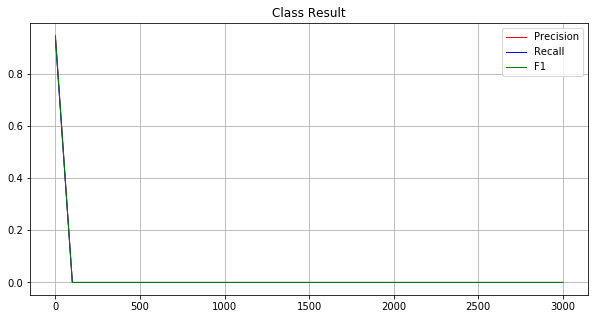

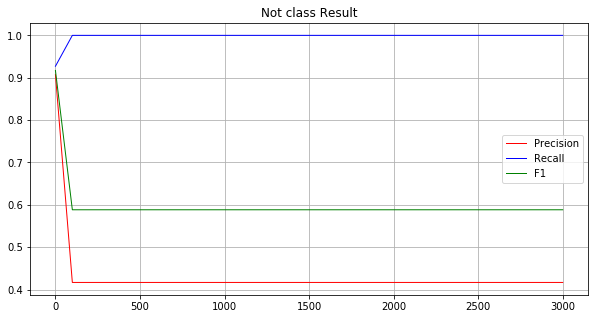

In [0]:
plot_results(train_docs, min_threshold=0, max_threshold=3000, step=100, trace=1)

In [0]:
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = load_csv(TEST_DATA_FILE, calc_features)

In [0]:
TEST_DATA_FILE  = 'kaggle_test_data_tab.csv.gz'
# TEST_DATA_FILE  = 'kaggle/kaggle_train_data_tab_300.csv.gz'

test_docs = load_csv(TEST_DATA_FILE, calc_features)

threshold = 0

with open('my_submission.csv' , 'w') as fout:
    writer = csv.writer(fout)
    writer.writerow(['Id','Prediction'])
    for num, item in enumerate(classifier.predict_all(test_docs)):

        prediction =  1 if item[3] == True else 0
        writer.writerow([item[0], prediction])

17:20:33 INFO:Complete items 00000
17:20:33 INFO:Complete items 00000
17:21:11 INFO:Complete items 01000
17:21:11 INFO:Complete items 01000
17:21:46 INFO:Complete items 02000
17:21:46 INFO:Complete items 02000
17:22:17 INFO:Complete items 03000
17:22:17 INFO:Complete items 03000
17:22:45 INFO:Complete items 04000
17:22:45 INFO:Complete items 04000
17:23:12 INFO:Complete items 05000
17:23:12 INFO:Complete items 05000
17:23:45 INFO:Complete items 06000
17:23:45 INFO:Complete items 06000
17:24:14 INFO:Complete items 07000
17:24:14 INFO:Complete items 07000
17:24:42 INFO:Complete items 08000
17:24:42 INFO:Complete items 08000
17:25:13 INFO:Complete items 09000
17:25:13 INFO:Complete items 09000
17:25:51 INFO:Complete items 10000
17:25:51 INFO:Complete items 10000
17:26:19 INFO:Complete items 11000
17:26:19 INFO:Complete items 11000
17:26:48 INFO:Complete items 12000
17:26:48 INFO:Complete items 12000
17:27:13 INFO:Complete items 13000
17:27:13 INFO:Complete items 13000
17:27:41 INFO:Comple

In [0]:
train_docs

[DocItem(doc_id=-9222401963271173253, is_spam=False, url='http://lawleader.ru/docs/32/', features=[13071, 2.20434549766659, 11, 5, 0]),
 DocItem(doc_id=-9221399504663603656, is_spam=False, url='http://alterhost.ruwww.alterhost.ruwww.user.kz.ru/', features=[2049, 2.6012689116642265, 8, 5, 0]),
 DocItem(doc_id=-9219733223042265364, is_spam=False, url='http://www.ferio.ru/c_1-acura-legend.html', features=[4212, 2.221272554605888, 17, 10, 0]),
 DocItem(doc_id=-9218561774155397294, is_spam=False, url='http://fshops.otzyv.ru/read.php?id=277', features=[2647, 2.365697015489233, 12, 0, 0]),
 DocItem(doc_id=-9216163564171210203, is_spam=True, url='http://penhea895.narod.ru/familiya-shushmarchenko.html', features=[1639, 2.1287370347773034, 28, 5, 0]),
 DocItem(doc_id=-9213263092469495632, is_spam=True, url='http://ntklhjdawv5.edu.ms/5/open24-ru-znakomstva-97.html', features=[3384, 2.1660756501182035, 34, 0, 0]),
 DocItem(doc_id=-9210905935710158021, is_spam=True, url='http://cursedec69.110mb.com

In [0]:
soup = BeautifulSoup('<html><body><a> Some text </a>')
soup.find('a').text

' Some text '